# Scrape and analyzing kost-kostan in South Jakarta

## Scraping the data from sewakost website

In [1]:
import requests
import pandas as pd
from tqdm import tqdm

In [ ]:
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

In [21]:
url_query = "https://www.sewakost.com/jakarta/selatan/"
req = requests.get(url_query, verify=False)
soup = BeautifulSoup(req.content, "html.parser")
str(soup)[:100]

'<!DOCTYPE html>\n\n<html lang="id" xmlns="http://www.w3.org/1999/xhtml">\n<head>\n<title>Kost Jakarta Se'

In [3]:
try:
    find_pagination = soup.find("ul", attrs = {"class": "pagination"})
    find_span = find_pagination.findAll("span")
    total_page = int(find_span[1].text[-2:])
    print("Total Page: {}".format(total_page))
except:
    print("Article Not Found")

Total Page: 89


In [11]:
sewakost = []

for page_num in tqdm(range(1, total_page+1)[:40]):
    url_sewakost = "https://www.sewakost.com/jakarta/selatan/index%s.html" % page_num
    # print(url_sewakost)
    r = requests.get(url_sewakost, verify=False)
    s = BeautifulSoup(r.content, "html.parser")
    
    find_kos = s.findAll("div", attrs = {"class": "main-column clearfix"})
    for row in find_kos:
        try:
          kos = {}
          kos['url'] = row.ul.li.a['href']
          kos['nama'] = row.ul.li.a['title']
          harga = row.find("span", attrs = {"class": "price-tag"})
          kos['harga'] = harga.span.text
          sewakost.append(kos)
        except:
          continue
        

100%|██████████| 40/40 [00:58<00:00,  1.46s/it]


In [12]:
pd.DataFrame(sewakost)

,url,nama,harga
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,Rp 1.000.000
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,Rp 2.200.000
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,Rp 850.000
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,Rp 2.700.000
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,Rp 2.500.000
...,...,...,...
953,https://www.sewakost.com/jakarta/selatan/kost-...,Kost lokasi Strategis dan Aman,Rp 2.200.000
954,https://www.sewakost.com/jakarta/selatan/kosan...,Kosan 28 Duren Tiga (Bangunan Baru!!),Rp 1.100.000
955,https://www.sewakost.com/jakarta/selatan/kost-...,"Kost Khusus Putra di Tebet Timur Dalam 7G, Jak...",Rp 1.900.000
956,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Putri Qtha,Rp 1.400.000


In [24]:
for kos in tqdm(sewakost):
  try:
    req_kos = requests.get(kos['url'], verify = False)
    soup_kos = BeautifulSoup(req_kos.content, "html.parser")

    informasi = ['jenis', 'address', 'aircon', 'free_wifi', 'kamar_mandi_dalam']

    for info in informasi:
      value = soup_kos.find("div", attrs={"id": "df_field_%s" % info}).find("div", attrs={"class":"value"})
      kos[info] = value.text.strip()

    kos['fasilitas_kamar'], kos['fasilitas_kost'] = [], []
    fasilitas = ['fasilitas_kamar', 'fasilitas_kost']

    for f in fasilitas:
      list_f = soup_kos.find("div", attrs={"id": "df_field_%s" % f}).find("div", attrs={"class":"value"})
      for each_f in list_f.findAll("li"):
        kos[f].append(each_f['title'])

  except:
    pass

100%|██████████| 958/958 [23:26<00:00,  1.47s/it]


In [ ]:
pd.DataFrame(sewakost).to_csv('sewakost_40pages.tsv', sep="\t", index=False)

## Data Preparation

In [2]:
df = pd.read_csv('sewakost_40pages.tsv', sep="\t")

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,Rp 1.000.000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,Rp 2.200.000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,Rp 850.000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,Rp 2.700.000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,Rp 2.500.000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


In [43]:
df.isnull().sum()

url                   0
nama                  0
harga                 0
jenis                14
address              14
aircon               14
free_wifi            14
kamar_mandi_dalam    14
fasilitas_kamar      14
fasilitas_kost       14
dtype: int64

In [3]:
df[df.isnull().any(axis=1)]

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
483,https://www.sewakost.com/jakarta/selatan/indek...,INDEKOS ELITE DALAM CLUSTER FULL FURNISH,3.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
739,https://www.sewakost.com/jakarta/selatan/tebet...,TEBET EXECUTIVE RESIDENCE 141,3.550.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
740,https://www.sewakost.com/jakarta/selatan/sewa-...,"Sewa Kost, Cilandak Barat, Jakarta Selatan",2.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
741,https://www.sewakost.com/jakarta/selatan/kos-d...,Kos di Lt.Agung dkt KRL Lt.Agung & Tj.Brt,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
742,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Wanita Tebet Dekat Pasar Tebet Barat dan ...,1.600.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
743,https://www.sewakost.com/jakarta/selatan/kos-p...,Kos Putri Strategis,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
744,https://www.sewakost.com/jakarta/selatan/kos-k...,Kos khusus wanita,1.500.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
745,https://www.sewakost.com/jakarta/selatan/koen-...,Koen View Residence Radio Dalam,6.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
746,https://www.sewakost.com/jakarta/selatan/kos-d...,Kos di Lt.Agung dkt kampus dan KRL,700.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
747,https://www.sewakost.com/jakarta/selatan/kost-...,KOST ELITE CAMPUR FULL FURNISH JAKARTA SELATAN...,3.000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.dropna(inplace=True)

df.isnull().sum()

url                  0
nama                 0
harga                0
jenis                0
address              0
aircon               0
free_wifi            0
kamar_mandi_dalam    0
fasilitas_kamar      0
fasilitas_kost       0
dtype: int64

In [5]:
import re as re

def find_number(text):
    try:
        num = "".join(re.findall(r'[\d]+',text))
        return int(num)
    except:
        return 0

df['harga'] = df['harga'].apply(lambda x: find_number(x))

df.head()

,url,nama,harga,jenis,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
0,https://www.sewakost.com/jakarta/selatan/kost-...,Kost Ciganjur Jalan Pasir No. 32,1000000,Kost Campur,Jalan Pasir no 32 Kp. Setu Rt 001/006 Keluraha...,Tidak,Tidak,Ya,['Kamar Mandi Dalam'],"['Keamanan', 'Parkir Motor']"
1,https://www.sewakost.com/jakarta/selatan/kost-...,KOST EXECUTIVE JAGAKARSA PASO CILANDAK JAKARTA...,2200000,Kost Putra,"Jalan Paso no 6A, Jagakarsa, Cilandak, Jakarta...",Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Air Mi..."
2,https://www.sewakost.com/jakarta/selatan/kamar...,Kamar kost Putri NON AC di Mampang,850000,Kost Putri,Jl.Mampang Prapatan VI Rt04 Rw02 No.70B,Tidak,Tidak,Tidak,[],[]
3,https://www.sewakost.com/jakarta/selatan/hompy...,Hompy Timur Residence,2700000,Kost Putri,Tebet Timur Dalam 7B no. 11,Ya,Ya,Ya,"['Spring Bed', 'Perabot', 'Free WiFi', 'AC', '...","['Dapur', 'Cuci Setrika', 'Pembantu', 'Keamana..."
4,https://www.sewakost.com/jakarta/selatan/rumah...,Rumah kontrakan (40m2) Pasutri baru/karyawati/...,2500000,Kost Pasutri,Jalan keselamatan 18 RT10/RW03,Ya,Tidak,Ya,"['AC', 'Kamar Mandi Dalam']","['Ruang Tamu', 'Ruang Makan', 'Dapur', 'Keaman..."


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944 entries, 0 to 957
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   url                944 non-null    object
 1   nama               944 non-null    object
 2   harga              944 non-null    int64 
 3   jenis              944 non-null    object
 4   address            944 non-null    object
 5   aircon             944 non-null    object
 6   free_wifi          944 non-null    object
 7   kamar_mandi_dalam  944 non-null    object
 8   fasilitas_kamar    944 non-null    object
 9   fasilitas_kost     944 non-null    object
dtypes: int64(1), object(9)
memory usage: 81.1+ KB


In [6]:
df['jenis'].unique()

array(['Kost Campur', 'Kost Putra', 'Kost Putri', 'Kost Pasutri',
       'Kost Keluarga'], dtype=object)

In [7]:
df.groupby('jenis').count()

,url,nama,harga,address,aircon,free_wifi,kamar_mandi_dalam,fasilitas_kamar,fasilitas_kost
jenis,,,,,,,,,
Kost Campur,534,534,534,534,534,534,534,534,534
Kost Keluarga,9,9,9,9,9,9,9,9,9
Kost Pasutri,16,16,16,16,16,16,16,16,16
Kost Putra,116,116,116,116,116,116,116,116,116
Kost Putri,269,269,269,269,269,269,269,269,269


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

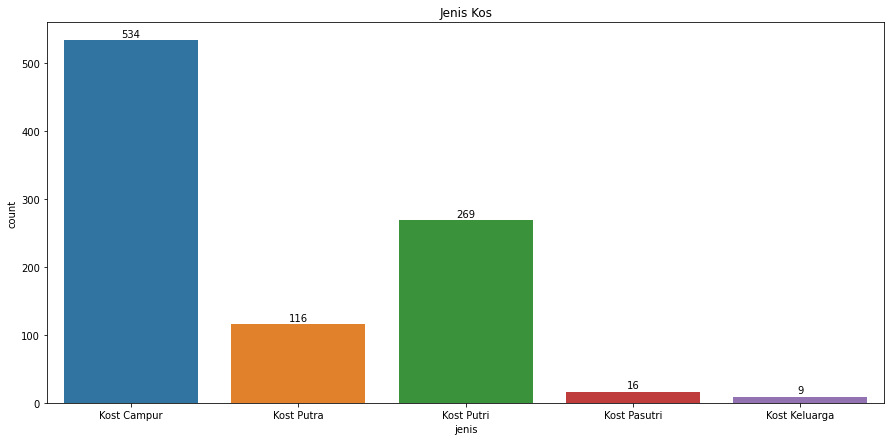

In [29]:
plt.figure(figsize=(15,7))
g = sns.countplot(x=df['jenis'])
plt.title('Jenis Kos')
for p in g.patches:
  g.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+5), ha='center', color='black', size=10)

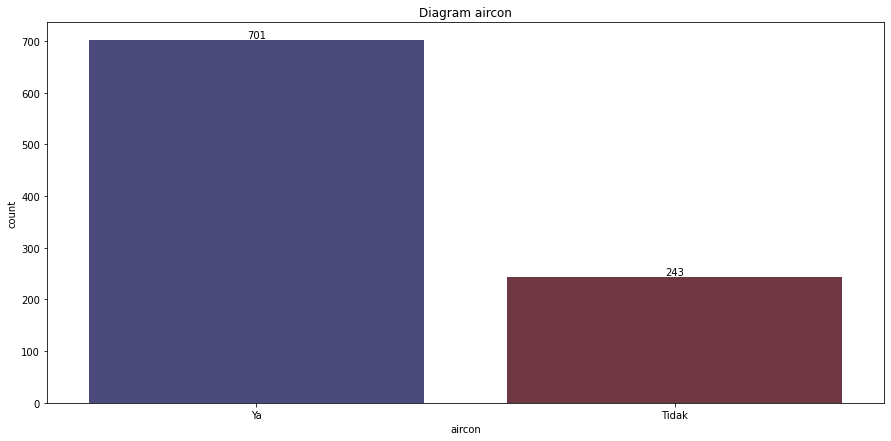

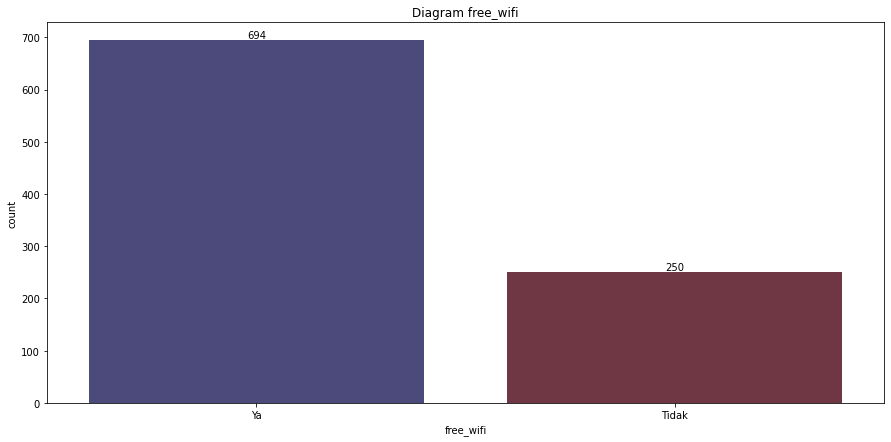

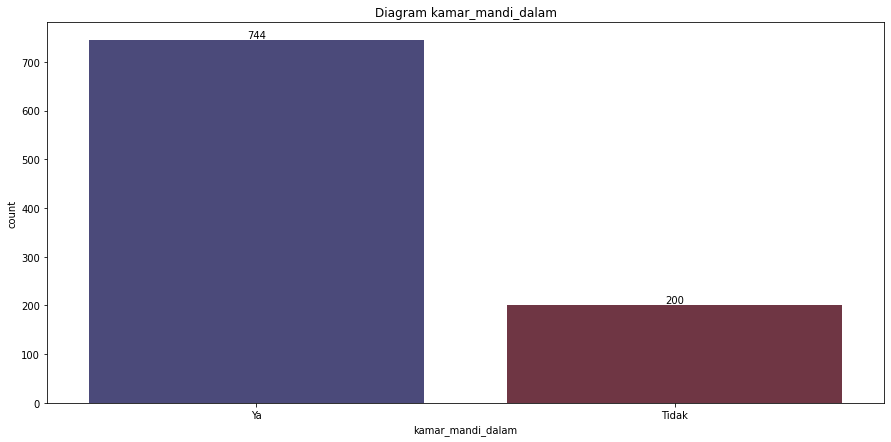

In [41]:
for i in ['aircon', 'free_wifi', 'kamar_mandi_dalam'] :
    plt.figure(figsize=(15,7))
    g = sns.countplot(x = df[i], palette = 'icefire', order=['Ya', 'Tidak'])
    plt.title('Diagram {}'.format(i))
    for p in g.patches:
        g.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+5), ha='center', color='black', size=10)

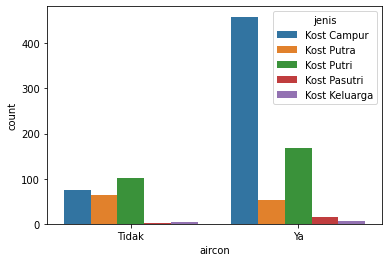

In [43]:
sns.countplot(data=df, x="aircon", hue="jenis");